# Purpose


**2023-04-11**:<br>
<br> In this notebook we'll try an end-to-end process to get ANN for 2 different subreddits.

- Pull data:
    - User Time on Subreddit (save to local now, GCS in prod)
    - Get subreddit-level embeddings (save to local, GCS in prod)
- Reshape to get user-embeddings
    - _(Load/cache files to local drive to speed up processing in prod)_
    - Expand subreddit-level embeddings & save as a new file
    - Expand ToSub to long format & save to file
    - For each ToSub file, get weighted embeddings for a user
        - Save user-level (weighted) embeddings to file
- Calculate ANN distance to input subreddit(s)
    - Load all user-embeddings & create an index with ANNOY
    - Load subreddit-embedding file
    - For each input target subreddit, get the ANN users
        - Try nearest 3 million users
        - **`TODO(djb)`**: how do I ensure that there are at least 100k users from each target country?
    - Save raw ANN file
- Reshape ANN table & upload to BQ table:
    - Reshape ANN file for BigQuery format
    - Upload ANN file to BQ for table creation




# Imports & Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime
import gc
import logging
from logging import info
import os
from pathlib import Path
import json

import polars as pl
import numpy as np
import pandas as pd
import plotly
import seaborn as sns

from tqdm.auto import tqdm
import dask
import mlflow

import subclu
from subclu.eda.aggregates import compare_raw_v_weighted_language
from subclu.utils import set_working_directory, get_project_subfolder
from subclu.utils.eda import (
    setup_logging, counts_describe, value_counts_and_pcts,
    notebook_display_config, print_lib_versions,
    style_df_numeric, reorder_array,
)
from subclu.utils.mlflow_logger import MlflowLogger
from subclu.utils.hydra_config_loader import LoadHydraConfig
from subclu.utils.data_irl_style import (
    get_colormap, theme_dirl, 
    get_color_dict, base_colors_for_manual_labels,
    check_colors_used,
)
from subclu.data.data_loaders import LoadPosts, LoadSubreddits, create_sub_level_aggregates


# ===
# imports specific to this notebook
from google.cloud import bigquery
from subclu.pn_models import get_data


client = bigquery.Client()

print_lib_versions([bigquery, np, pd, pl, plotly, mlflow, subclu])

python		v 3.7.10
===
google.cloud.bigquery	v: 2.13.1
numpy		v: 1.19.5
pandas		v: 1.2.4
polars		v: 0.17.1
plotly		v: 5.11.0
mlflow		v: 1.16.0
subclu		v: 0.6.1


In [3]:
# plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
plt.style.use('default')

setup_logging()
notebook_display_config()

# Get data

## Get subreddit-level embeddings

For this part BigQuery + pandas is fast enough.

In [4]:
%%time
%%bigquery df_sub_emb_raw --project data-science-prod-218515 

-- This aggregation is a pain to unnest, but it's the best we have (can't trust UNNESTING in SQL becuse order is not guaranteed)
SELECT
  subreddit_id
  , subreddit_name
  , ARRAY_CONCAT(embedding) AS embedding
FROM `data-prod-165221.ml_content.subreddit_embeddings_ft2`
WHERE DATE(pt) = '2023-04-04'

Downloading: 100%|██████████| 242345/242345 [00:03<00:00, 66293.55rows/s] 


CPU times: user 720 ms, sys: 454 ms, total: 1.17 s
Wall time: 5.58 s


In [5]:
df_sub_emb_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242345 entries, 0 to 242344
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   subreddit_id    242345 non-null  object
 1   subreddit_name  242345 non-null  object
 2   embedding       242345 non-null  object
dtypes: object(3)
memory usage: 5.5+ MB


In [6]:
df_sub_emb_raw.head()

,subreddit_id,subreddit_name,embedding
0,t5_4f57cs,fuckangelhernandez,"[-0.3996698260307312, 0.20269957184791565, -0.3055022060871124, -0.005287058185786009, 0.121136873960495, 0.06231916323304176, -0.37654876708984375, 0.48437756299972534, -0.2151433378458023, 0.31947633624076843, 0.4782879948616028, 0.23..."
1,t5_2s2gt,fuckapple,"[-0.0029481418896466494, 0.053129445761442184, -0.17849114537239075, -0.1555848866701126, -0.20715922117233276, 0.2648947238922119, 0.24177874624729156, 0.23757821321487427, 0.011948454193770885, 0.3712220788002014, 0.3585907518863678, ..."
2,t5_7s1lcv,fuckaround_n_findout,"[-0.25010135769844055, -0.05121876671910286, -0.4104999303817749, 0.17199638485908508, -0.2111128717660904, -0.01367927622050047, -0.41924068331718445, 0.15966467559337616, 0.1576160341501236, 0.398811936378479, 0.3563167154788971, 0.07..."
3,t5_2mpk27,fuckautismspeaks,"[-0.643264889717102, -0.3077889084815979, -0.8766250610351562, 0.34814009070396423, -0.3688446581363678, -0.09676993638277054, -0.01420139241963625, 0.11278355121612549, 0.2917800843715668, 0.48437413573265076, -0.09958196431398392, -0...."
4,t5_5rkktn,fuckbagin,"[0.09801478683948517, -0.26190200448036194, 0.09046468883752823, -0.18976961076259613, -0.06223154440522194, 0.34227171540260315, -0.07571414113044739, 0.3605010509490967, 0.013768891803920269, 0.4096928536891937, 0.27020058035850525, -..."


## Get Time-on-Subreddit (ToS) for target user IDs

We'll use these to create weighted embeddings.

I'm caching the `selected users` in a table so that it's easier/faster to re-use while testing.

The time-on-subreddit feature is already in gazette features so we don't need to waste time computing them.

Key tables:
- Select users:
    - `data-prod-165221.fact_tables.post_consume_post_detail_view_events` 
- Get ToS:
    - `data-prod-165221.user_feature_platform.time_on_subreddit_pct_time_over_30_day_v1`
    
 ---


Pulling the raw data (1-row per user )
Time ETAs:

| Description | 0.85 Million Users  | 9.8 Million Users |
|---|---|---|
| Query & load 1-row per user in python  | 37 seconds  | n/a |
| Explode to exploded (1-row per user<>subreddit)  | 5 minutes (in Python)  | 1 minute (in BigQuery) |
| Export exploded to GCS | n/a  | 1 minute (in BigQuery. 1,500 files) |
| Download from GCS  | n/a  | 1 minute (with `gsutil`) |
| Load from Local  | n/a  | 15 **seconds** (with `pl.read_parquet()`) |
| Total Time  | ~6 minutes | ~3 minutes  |
| Total Rows  | 130,601,209 | 851,107,537  |

**Note** that for the new format I'm excluding ToS that is less than 0.0001 (0.01 %).
- For 9.8 million users: reduces from 1.1 **B**illion rows to 851 **M**illion

--- 
Load data from GCS because loading straight from BQ takes too long (stopped after waiting for 30 minutes). 

```bash
# Copy: the -n flag only copies "NEW" files
# !gsutil -o GSUtil:parallel_thread_count=20 -o GSUtil:parallel_process_count=20 -m cp -r -n $remote_gs_path $local_f

# rsync can be nicer because with `-n` you get a preview (dry run) before running a command
# !gsutil -o GSUtil:parallel_thread_count=20 -o GSUtil:parallel_process_count=20 -m rsync -r -n $gcs_tos $local_path_tos
```

Note that it's better to run this command from the CLI because it can crash jupyter (fast log info 

In [7]:
gcs_tos = "gs://i18n-subreddit-clustering/pn_model/runs/20230413/user_tos_30_pct/"

path_local_cache = Path("/home/jupyter/subreddit_clustering_i18n/data/local_cache/i18n-subreddit-clustering/")
local_path_tos = path_local_cache / "pn_model/runs/20230413/user_tos_30_pct/"
Path.mkdir(local_path_tos, exist_ok=True, parents=True)


print(f"GCS URI:\n  {gcs_tos}\nLocal path:\n  {local_path_tos}")

print(f"\nCLI command:")
!echo gsutil -o GSUtil:parallel_thread_count=20 -o GSUtil:parallel_process_count=20 -m rsync -r -n $gcs_tos $local_path_tos

GCS URI:
  gs://i18n-subreddit-clustering/pn_model/runs/20230413/user_tos_30_pct/
Local path:
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/i18n-subreddit-clustering/pn_model/runs/20230413/user_tos_30_pct

CLI command:
gsutil -o GSUtil:parallel_thread_count=20 -o GSUtil:parallel_process_count=20 -m rsync -r -n gs://i18n-subreddit-clustering/pn_model/runs/20230413/user_tos_30_pct/ /home/jupyter/subreddit_clustering_i18n/data/local_cache/i18n-subreddit-clustering/pn_model/runs/20230413/user_tos_30_pct


In [8]:
# %%time

# bq_user_tos = """
# SELECT
#     *
# FROM `reddit-employee-datasets.david_bermejo.pn_test_user_tos_30_pct_20230413`
# LIMIT 10000
# ;
# """

# info(f"Start query...")
# df_user_tos_sample = pl.from_arrow(client.query(bq_user_tos).to_arrow())
# info(f"Complete query")

In [9]:
%%time

df_user_tos = pl.read_parquet(f"{local_path_tos}/*.parquet")

CPU times: user 1min 59s, sys: 27.6 s, total: 2min 27s
Wall time: 13.3 s


In [10]:
df_user_tos.shape

(851107537, 3)

In [11]:
%%time
df_user_tos.sample(n=int(1e6)).describe()

CPU times: user 7.28 s, sys: 338 ms, total: 7.62 s
Wall time: 6.32 s


describe,user_id,subreddit_id,tos_30_pct
str,str,str,f64
"""count""","""1000000""","""1000000""",1e6
"""null_count""","""0""","""0""",0.0
"""mean""",null,null,0.011546
"""std""",null,null,0.050877
"""min""","""t2_1000g6""","""t5_1009a3""",0.0001
"""max""","""t2_zzzz9""","""t5_zzszh""",1.0
"""median""",null,null,0.00104


In [12]:
df_user_tos.head()

user_id,subreddit_id,tos_30_pct
str,str,f64
"""t2_100rqi""","""t5_2ti4h""",0.00669
"""t2_100413""","""t5_2w2f5""",0.0019
"""t2_100413""","""t5_vt09k""",0.00013
"""t2_100413""","""t5_5ru0qk""",0.00015
"""t2_100k13""","""t5_2qh0u""",0.00638


# Transform - sub embeddings to wide

In [13]:
n_emb_cols = df_sub_emb_raw['embedding'].iloc[0].shape[0]
assert np.alltrue(n_emb_cols == df_sub_emb_raw['embedding'].str.len())


embedding_col_prefix = 'embedding_'
l_emb_cols = [f"{embedding_col_prefix}{i:03,.0f}" for i in range(n_emb_cols)]
print(len(l_emb_cols))

100


In [14]:
%%time

df_sub_emb_pd = pd.DataFrame(
    list(df_sub_emb_raw['embedding']),
    columns=l_emb_cols,
    index=pd.MultiIndex.from_frame(df_sub_emb_raw[['subreddit_id', 'subreddit_name']]),
).reset_index()

print(df_sub_emb_pd.shape)

(242345, 102)
CPU times: user 12 s, sys: 712 ms, total: 12.7 s
Wall time: 12.7 s


In [15]:
%%time

df_sub_emb_pd = pd.DataFrame(
    list(df_sub_emb_raw['embedding']),
    columns=l_emb_cols,
    index=pd.MultiIndex.from_frame(df_sub_emb_raw[['subreddit_id', 'subreddit_name']]),
).reset_index()

print(df_sub_emb_pd.shape)

(242345, 102)
CPU times: user 12.2 s, sys: 548 ms, total: 12.7 s
Wall time: 12.7 s


In [16]:
df_sub_emb_pd.iloc[:5, :15]

,subreddit_id,subreddit_name,embedding_000,embedding_001,embedding_002,embedding_003,embedding_004,embedding_005,embedding_006,embedding_007,embedding_008,embedding_009,embedding_010,embedding_011,embedding_012
0,t5_4f57cs,fuckangelhernandez,-0.399670,0.202700,-0.305502,-0.005287,0.121137,0.062319,-0.376549,0.484378,-0.215143,0.319476,0.478288,0.231356,0.363155
1,t5_2s2gt,fuckapple,-0.002948,0.053129,-0.178491,-0.155585,-0.207159,0.264895,0.241779,0.237578,0.011948,0.371222,0.358591,-0.179012,-0.084831
2,t5_7s1lcv,fuckaround_n_findout,-0.250101,-0.051219,-0.410500,0.171996,-0.211113,-0.013679,-0.419241,0.159665,0.157616,0.398812,0.356317,0.077186,-0.042314
3,t5_2mpk27,fuckautismspeaks,-0.643265,-0.307789,-0.876625,0.348140,-0.368845,-0.096770,-0.014201,0.112784,0.291780,0.484374,-0.099582,-0.736010,-0.301874
4,t5_5rkktn,fuckbagin,0.098015,-0.261902,0.090465,-0.189770,-0.062232,0.342272,-0.075714,0.360501,0.013769,0.409693,0.270201,-0.038233,-0.322011


In [17]:
%%time
# convert it to polars to speed up processing
df_sub_emb = pl.from_pandas(df_sub_emb_pd)

print(df_sub_emb.shape)

(242345, 102)
CPU times: user 109 ms, sys: 19.2 ms, total: 128 ms
Wall time: 126 ms


In [18]:
df_sub_emb[:5, :15]

subreddit_id,subreddit_name,embedding_000,embedding_001,embedding_002,embedding_003,embedding_004,embedding_005,embedding_006,embedding_007,embedding_008,embedding_009,embedding_010,embedding_011,embedding_012
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""t5_4f57cs""","""fuckangelherna…",-0.39967,0.2027,-0.305502,-0.005287,0.121137,0.062319,-0.376549,0.484378,-0.215143,0.319476,0.478288,0.231356,0.363155
"""t5_2s2gt""","""fuckapple""",-0.002948,0.053129,-0.178491,-0.155585,-0.207159,0.264895,0.241779,0.237578,0.011948,0.371222,0.358591,-0.179012,-0.084831
"""t5_7s1lcv""","""fuckaround_n_f…",-0.250101,-0.051219,-0.4105,0.171996,-0.211113,-0.013679,-0.419241,0.159665,0.157616,0.398812,0.356317,0.077186,-0.042314
"""t5_2mpk27""","""fuckautismspea…",-0.643265,-0.307789,-0.876625,0.34814,-0.368845,-0.09677,-0.014201,0.112784,0.29178,0.484374,-0.099582,-0.73601,-0.301874
"""t5_5rkktn""","""fuckbagin""",0.098015,-0.261902,0.090465,-0.18977,-0.062232,0.342272,-0.075714,0.360501,0.013769,0.409693,0.270201,-0.038233,-0.322011


# Other Transforms 

We don't need these transforms for ANN, but will use it for modeling step
- Count of subreddits per user for ToS

Other data:
- Subscribed to target subreddit
- Age of account
- Activity in L14 days
- etc...



---


# Compute user-level weighted embedding

now that we have the long df, let's compute the user-level weighted embedding (multiply weights x embedding & groupby user-id)

## Test on a subset

In [19]:
%%time

sample_users = df_user_tos['user_id'].sample(n=int(1e4)).unique().sort()[:500]
print(sample_users.shape)
sample_users.head()

(500,)
CPU times: user 6.19 s, sys: 1.56 s, total: 7.75 s
Wall time: 7.74 s


user_id
str
"""t2_100z5u2"""
"""t2_101fla"""
"""t2_101hpt"""
"""t2_1024t2"""
"""t2_102gfl"""
"""t2_102mhu4k"""
"""t2_103fb1"""
"""t2_103rbu"""
"""t2_1042pspu"""


TODO(djb): There are subreddits w/o embeddings.. what do we do about those?

- For now, I'm dropping them
- Potentially could fillnulls with the `median` subreddit
    - Take the median of all subreddits and `.fillna` with the median vector.

### Eager execution

In [20]:
%%time

info(f"Append subreddit embeddings to user ToS")
# Use .join() instead of .filter()!! .filter() is like 8x slower!! (2 secs instead of 16 secs)
df_user_emb_tmp_test = (
    df_user_tos
    .join(
        pl.DataFrame(sample_users),
        how='inner',
        on=['user_id'],
    )
    # .filter(
    #     # Use .join() instead of .filter()!! .filter() is like 8x slower!!
    #     df_user_tos['user_id'].is_in(sample_users)
    # )
    .join(
        df_sub_emb.drop('subreddit_name'),
        how='left',
        on=['subreddit_id']
    )
    # Drop or replace nulls as early as possible
    .drop_nulls()
)
info(f"{df_user_emb_tmp_test.shape} <- df.shape ToS with raw embeddings (no nulls)")

info(f"Compute weighted avg embedding for user-level")
df_user_emb_tmp_wt_test = (
    df_user_emb_tmp_test[['user_id', 'subreddit_id']]
    .with_columns(
        pl.DataFrame(
            data=((df_user_emb_tmp_test['tos_30_pct'].to_numpy()) * df_user_emb_tmp_test[l_emb_cols].to_numpy().T).T,
            schema=l_emb_cols,
        )
    )
)
info(f"{df_user_emb_tmp_wt_test.shape} <- df.shape ToS with weighted embedddings")


info(f"Compute AGGREGATED user-level embedding...")
df_user_emb_test = (
    df_user_emb_tmp_wt_test
    .groupby(
        ['user_id']
    )
    .agg(
        [
            pl.col(l_emb_cols).mean()
        ]
    )
)
info(f"{df_user_emb_test.shape} <- df.shape User weighted embedddings")
print(df_user_emb_test.shape)

08:29:01 | INFO | "Append subreddit embeddings to user ToS"
08:29:03 | INFO | "(70596, 103) <- df.shape ToS with raw embeddings (no nulls)"
08:29:03 | INFO | "Compute weighted avg embedding for user-level"
08:29:03 | INFO | "(70596, 102) <- df.shape ToS with weighted embedddings"
08:29:03 | INFO | "Compute AGGREGATED user-level embedding..."
08:29:03 | INFO | "(500, 101) <- df.shape User weighted embedddings"


(500, 101)
CPU times: user 2min 20s, sys: 18.1 s, total: 2min 38s
Wall time: 2.06 s


In [21]:
%%time

# TODO(djb) Could I re-write a single, long chain?


CPU times: user 10 µs, sys: 2 µs, total: 12 µs
Wall time: 22.9 µs


In [22]:
%%time

pl.DataFrame(
            data=((df_user_emb_tmp['tos_30_pct']) * df_user_emb_tmp[l_emb_cols].transpose()).transpose(),
            schema=l_emb_cols,
        )

In [23]:
# df_user_emb_test[:5, :15]

## Run on all users

Batches of 150-million user<>subreddit weighted embeddings was too much memory (over 1.2 TB). So the kernel gets killed.

```bash
# 800k users | 130 million ToS rows
07:08:08 | INFO | "Append subreddit embeddings to user ToS"
07:08:13 | INFO | "Compute weighted avg embedding for user-level"
07:09:49 | INFO | "Compute AGGREGATED user-level embedding..."
(130601209, 100)
(856211, 101)
CPU times: user 18min 9s, sys: 8min 21s, total: 26min 31s
Wall time: 4min 52s


# 9.8 million users |  million ToS rows

```

In [24]:
%%time

# When computing on full data set, we need to batch b/c the computer will run out of RAM if/when converting parquet to numpy
n_sample = int(10e6)
batch_size = int(1e6)  # 9e6 = 9Million
# iter_chunks = range(1 + len(df_user_tos) // batch_size)
iter_chunks = range(1 + n_sample // batch_size)
info(f"{n_sample:09,.0f} <- Sample")
info(f"{batch_size:09,.0f} <- Batch Size")

info(f"Append subreddit embeddings to user ToS")
df_user_emb_tmp = (
    df_user_tos
    .sample(n=n_sample, seed=42)
    .join(
        df_sub_emb.drop('subreddit_name'),
        how='left',
        on=['subreddit_id']
    )
    # Drop or replace nulls as early as possible
    .drop_nulls()
)
info(f"{df_user_emb_tmp.shape} <- df.shape ToS with raw embeddings (no nulls)")
gc.collect()

info(f"Compute weighted avg embedding for user-level")
df_user_emb_tmp_wt = (
    pl.select(
        df_user_emb_tmp[['user_id', 'subreddit_id']]
    )
    .with_columns(
        pl.DataFrame(
            data=((df_user_emb_tmp['tos_30_pct'].to_numpy()) * df_user_emb_tmp[l_emb_cols].to_numpy().T).T,
            schema=l_emb_cols,
        )
    )
)
info(f"{df_user_emb_tmp_wt.shape} <- df.shape ToS with weighted embedddings")
gc.collect()

info(f"Compute AGGREGATED user-level embedding...")
df_user_emb = (
    df_user_emb_tmp_wt
    .groupby(
        ['user_id']
    )
    .agg(
        [
            pl.col(l_emb_cols).mean()
        ]
    )
)
info(f"{df_user_emb.shape} <- df.shape User weighted embedddings")
gc.collect()
print(df_user_emb.shape)

08:29:03 | INFO | "10,000,000 <- Sample"
08:29:03 | INFO | "1,000,000 <- Batch Size"
08:29:03 | INFO | "Append subreddit embeddings to user ToS"
08:29:11 | INFO | "(8982315, 103) <- df.shape ToS with raw embeddings (no nulls)"
08:29:11 | INFO | "Compute weighted avg embedding for user-level"
08:29:17 | INFO | "(8982315, 102) <- df.shape ToS with weighted embedddings"
08:29:18 | INFO | "Compute AGGREGATED user-level embedding..."
08:29:20 | INFO | "(4850902, 101) <- df.shape User weighted embedddings"


(4850902, 101)
CPU times: user 3min 28s, sys: 1min 3s, total: 4min 31s
Wall time: 16.7 s


In [ ]:
%%time

pl.DataFrame(
            data=((df_user_emb_tmp['tos_30_pct']) * df_user_emb_tmp[l_emb_cols].transpose()).transpose(),
            schema=l_emb_cols,
        )

08:05:33 | INFO | "851,107,537 <- Data Size"
08:05:33 | INFO | "150,000,000 <- Batch Size"
08:05:33 | INFO | "0,000,006 <- Chunks"
08:05:33 | INFO | "Append subreddit embeddings to user ToS"
08:06:48 | INFO | "(764565252, 103) <- df.shape ToS with raw embeddings (no nulls)"
08:06:49 | INFO | "Create DAG for weighted avg embedding per user+subreddit"


  0%|                                                     | 0/6 [00:00<?, ?it/s]

08:11:58 | INFO | "Dask visualize DAG"


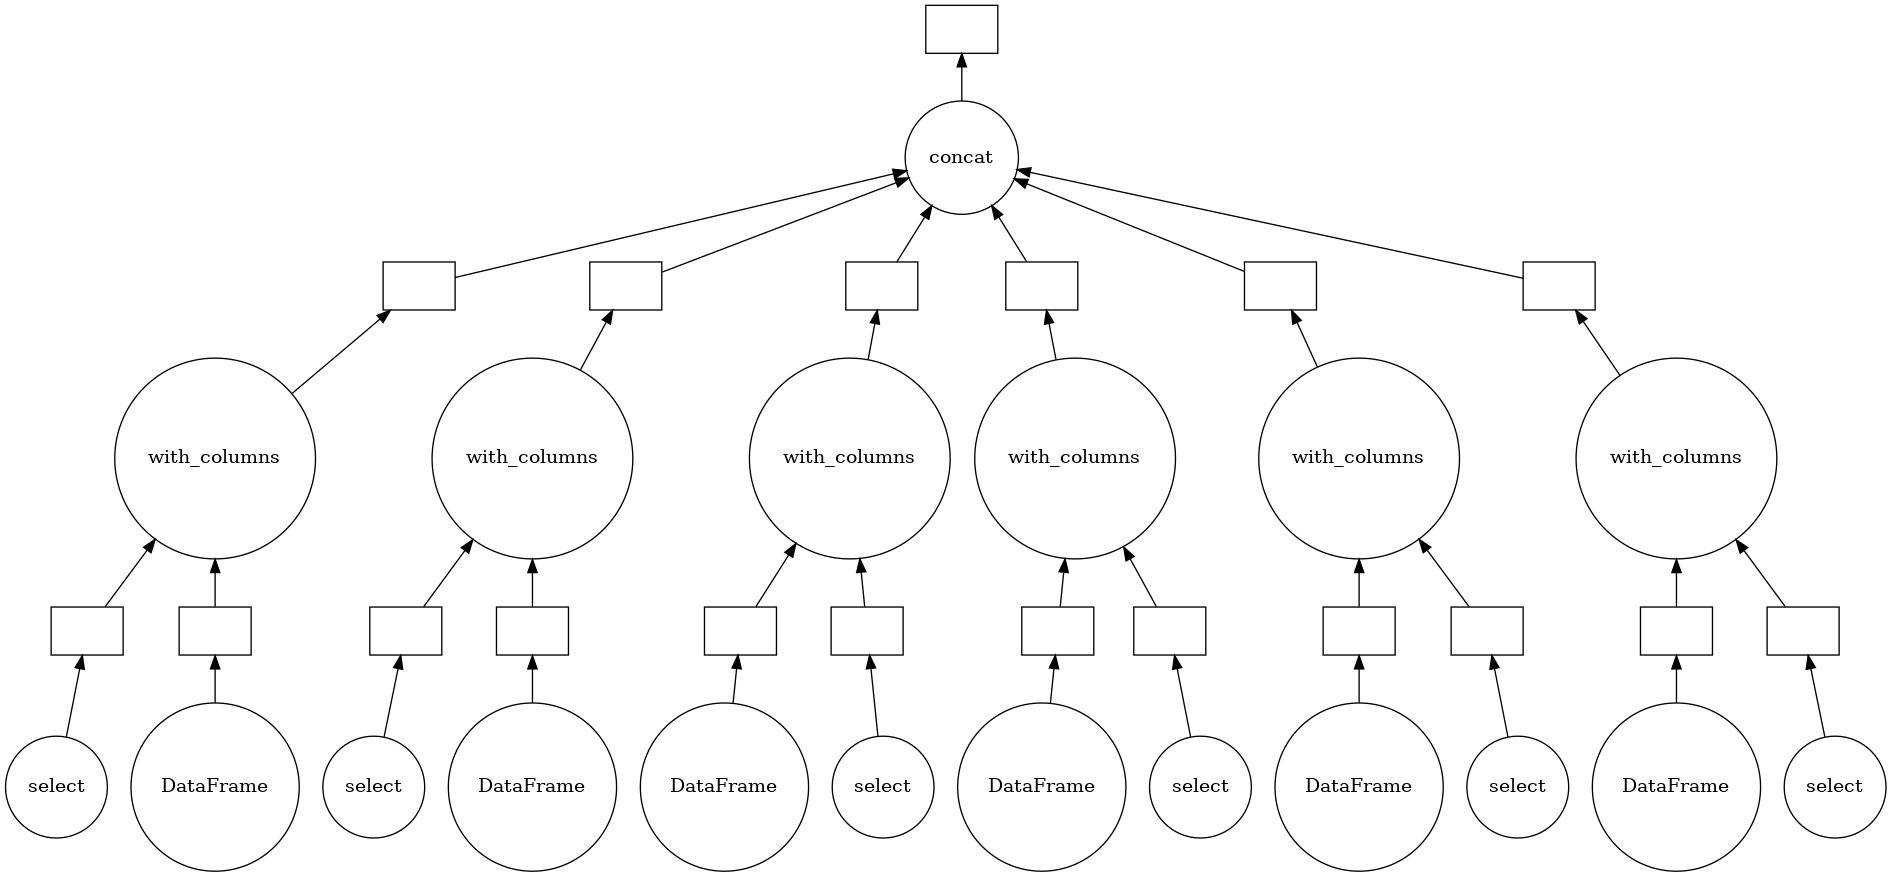

08:11:59 | INFO | "COMPUTE df_tos_long START"


In [ ]:
%%time

# when computing on full data set, we need to batch b/c the computer will run out of RAM if/when converting parquet to numpy
n_sample = int(10e5)  # None  int(10e5)

if n_sample is None:
    df_user_tos_proc_ = df_user_tos
else:
    df_user_tos_proc_ = df_user_tos.sample(n=n_sample, seed=42)
n_size = len(df_user_tos_proc_)

batch_size = int(150e6)  # int(150e6), 9e6 = 9Million
n_chunks = 1 + n_size // batch_size
iter_chunks = range(n_chunks)

info(f"{n_size:09,.0f} <- Data Size")
info(f"{batch_size:09,.0f} <- Batch Size")
info(f"{n_chunks:09,.0f} <- Chunks")


info(f"Append subreddit embeddings to user ToS")
df_user_emb_tmp = (
    df_user_tos_proc_
    .join(
        df_sub_emb.drop('subreddit_name'),
        how='left',
        on=['subreddit_id']
    )
    # Drop or replace nulls as early as possible
    .drop_nulls()
)
info(f"{df_user_emb_tmp.shape} <- df.shape ToS with raw embeddings (no nulls)")
gc.collect()

info(f"Create DAG for weighted avg embedding per user+subreddit")
# Try dask.delayed() to compute these in parallel
l_dfs_tos_wt = list()
for i in tqdm(iter_chunks, mininterval=0.1, ascii=True):
    l_dfs_tos_wt.append(
        dask.delayed(pl.select)(
            df_user_emb_tmp[['user_id', 'subreddit_id']]
            [i * batch_size:(i + 1) * batch_size]
        )
        .with_columns(
            dask.delayed(pl.DataFrame)(
                data=(
                    (df_user_emb_tmp['tos_30_pct'][i * batch_size:(i + 1) * batch_size].to_numpy()) * 
                    df_user_emb_tmp[l_emb_cols][i * batch_size:(i + 1) * batch_size].to_numpy().T
                ).T,
                schema=l_emb_cols,
            )
        )
    )
df_user_emb_tmp_wt_del = dask.delayed(pl.concat)(l_dfs_tos_wt, how='vertical', parallel=True)
info(f"Dask visualize DAG")
display(df_user_emb_tmp_wt_del.visualize(
    f"dask_DAG-{n_size}_data-{batch_size}_batch_size-{n_chunks}_chunks.png"
))

info(f"COMPUTE df_tos_long START")
df_user_emb_tmp_wt = df_user_emb_tmp_wt_del.compute()
info(f"{df_user_emb_tmp_wt.shape} <- df.shape ToS with weighted embedddings")


info(f"Compute AGGREGATED user-level embedding...")
df_user_emb = (
    df_user_emb_tmp_wt
    .groupby(
        ['user_id']
    )
    .agg(
        [
            pl.col(l_emb_cols).mean()
        ]
    )
)
info(f"{df_user_emb.shape} <- df.shape User weighted embedddings")
gc.collect()
print(df_user_emb.shape)

In [1]:
%%time

n_mins_sample = 10.5
n_users_sample = df_user_tos['user_id'].n_unique()
n_users_target = 30e6

seq_proc_time = n_mins_sample * (n_users_target / n_users_sample) / 60
print(f"{seq_proc_time:,.2f} Hours to get user-embeddings SEQUENTIALLY")

NameError: name 'df_user_tos' is not defined

In [403]:
%%time

dfp_user_emb.write_parquet("djb_test_df_user_embeddings-IGNORE.parquet")

CPU times: user 4.13 s, sys: 594 ms, total: 4.73 s
Wall time: 4.59 s


# Other tests

## compare creating weighted matrix in pandas v. polars
polars is faster. but part of it might be that I'm creating an index and then resetting it...

in any case, sticking to polars as much as possible is probably better for consistency and performance

In [149]:
%%time
info(f"Append subreddit embeddings to user ToS")
df_user_emb_tmp_test = (
    df_user_tos
    .join(
        pl.DataFrame(sample_users),
        how='inner',
        on=['user_id'],
    )
    .join(
        df_sub_emb.drop('subreddit_name'),
        how='left',
        on=['subreddit_id']
    )
    # Drop or replace nulls as early as possible
    .drop_nulls()
)
info(f"{df_user_emb_tmp_test.shape} <- df.shape ToS with raw embeddings (no nulls)")

06:32:34 | INFO | "Append subreddit embeddings to user ToS"
06:32:36 | INFO | "(67217, 103) <- df.shape ToS with raw embeddings (no nulls)"


CPU times: user 2min 18s, sys: 12.1 s, total: 2min 30s
Wall time: 2.01 s


In [79]:
%%time

_pl = (
    df_user_emb_tmp_test[['user_id', 'subreddit_id']]
    .with_columns(
        pl.DataFrame(
            data=((df_user_emb_tmp_test['tos_30_pct'].to_numpy()) * df_user_emb_tmp_test[l_emb_cols].to_numpy().T).T,
            schema=l_emb_cols,
        )
    )
)
print(_pl.shape)

(67217, 102)
CPU times: user 337 ms, sys: 248 ms, total: 585 ms
Wall time: 69.3 ms


In [78]:
%%time
_pd = pd.DataFrame(
    ((df_user_emb_tmp_test['tos_30_pct'].to_numpy()) * df_user_emb_tmp_test[l_emb_cols].to_numpy().T).T,
    index=pd.MultiIndex.from_frame(df_user_emb_tmp_test[['user_id', 'subreddit_id']].to_pandas()),
    columns=l_emb_cols,
).reset_index()
print(_pd.shape)

(67217, 102)
CPU times: user 423 ms, sys: 42.5 ms, total: 466 ms
Wall time: 88.7 ms


In [80]:
_pd.equals(_pl.to_pandas())

True

In [82]:
%%timeit

_pl = (
    df_user_emb_tmp_test[['user_id', 'subreddit_id']]
    .with_columns(
        pl.DataFrame(
            data=((df_user_emb_tmp_test['tos_30_pct'].to_numpy()) * df_user_emb_tmp_test[l_emb_cols].to_numpy().T).T,
            schema=l_emb_cols,
        )
    )
)

51.5 ms ± 2.02 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [83]:
%%timeit
_pd = pd.DataFrame(
    ((df_user_emb_tmp_test['tos_30_pct'].to_numpy()) * df_user_emb_tmp_test[l_emb_cols].to_numpy().T).T,
    index=pd.MultiIndex.from_frame(df_user_emb_tmp_test[['user_id', 'subreddit_id']].to_pandas()),
    columns=l_emb_cols,
).reset_index()

67.3 ms ± 820 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Lazy calculation for weighted embeddings 
Lazy give us less info in between stages, but it *could* be faster (in theory) because the query optimizer would have more/better info for the whole DAG.

However, NVM for now. I'm using numpy in the middle to get the weighted values, so we need eager execution.

In [140]:
# %%time

# info(f"Append subreddit embeddings to user ToS")
# df_user_emb_tmp_test = (
#     df_user_tos
#     .lazy()
#     .filter(
#         df_user_tos['user_id'].is_in(sample_users)
#     )
#     .join(
#         df_sub_emb.drop('subreddit_name').lazy(),
#         how='left',
#         on=['subreddit_id']
#     )
#     # Drop or replace nulls as early as possible
#     .drop_nulls()
# )
# # Can't get shape of a lazy df
# # info(f"{df_user_emb_tmp_test.shape} <- df.shape ToS with raw embeddings (no nulls)")

# info(f"Compute weighted avg embedding for user-level")
# df_user_emb_tmp_wt_test = (
#     df_user_emb_tmp_test
#     .select(['user_id', 'subreddit_id'])
#     .with_columns(
#         pl.DataFrame(
#             data=((df_user_emb_tmp_test.select(['tos_30_pct']).to_numpy()) * df_user_emb_tmp_test.select([l_emb_cols]).to_numpy().T).T,
#             schema=l_emb_cols,
#         ).lazy()
#     )
# )
# # info(f"{df_user_emb_tmp_wt_test.shape} <- df.shape ToS with weighted embedddings")


# info(f"Compute AGGREGATED user-level embedding...")
# df_user_emb_test = (
#     pl.DataFrame(df_user_emb_tmp_wt_test_pd)
#     .groupby(
#         ['user_id']
#     )
#     .agg(
#         [
#             pl.col(l_emb_cols).mean()
#         ]
#     )
#     .collect()
# )
# info(f"{df_user_emb_test.shape} <- df.shape User weighted embedddings")
# print(df_user_emb_test.shape)

### We would need the weight computation in polars instead of numpy


a) I tried using .transpose() and multiplying, but for some reason this results in `Panic` errors.

b) Exploding & aggregating _could_ be faster (maybe) but in reality we lose a lot of time exploding & re-aggregating.

- https://stackoverflow.com/questions/74372173/python-polars-how-to-multiply-each-element-in-a-list-with-a-value-in-a-differen
- https://stackoverflow.com/questions/72490297/rust-polars-is-it-possible-to-explode-a-list-column-into-multiple-columns

#### A - Transpose (breaks)

In [111]:
df_user_emb_tmp_test[l_emb_cols].transpose().shape  # [:50, :]

(100, 67217)

In [112]:
df_user_emb_tmp_test['tos_30_pct'].shape  # [:50] * 100

(67217,)

In [119]:
# transpose multiplication works for a subset of rows (50, 5000), but it stops working for some reason
#. when we try on all rows

# df_user_emb_tmp_test['tos_30_pct'][:5000] * df_user_emb_tmp_test[l_emb_cols].transpose()[:5000, :]

In [118]:
# %%time

# # try with only polars (skip .to_numpy)

# _pl = (
#     df_user_emb_tmp_test[['user_id', 'subreddit_id']]
#     .with_columns(
#         pl.DataFrame(
#             data=((df_user_emb_tmp_test['tos_30_pct']) * df_user_emb_tmp_test[l_emb_cols].transpose()).transpose(),
#             schema=l_emb_cols,
#         )
#     )
# )
# print(_pl.shape)

#### B - Explode + Aggregate (too slow)

In [120]:
%%time
info(f"Append subreddit embeddings to user ToS")
df_user_emb_tmp_test_pl = (
    df_user_tos
    .filter(
        df_user_tos['user_id'].is_in(sample_users)
    )
    .join(
        pl.DataFrame(df_sub_emb_raw).drop('subreddit_name'),
        how='left',
        on=['subreddit_id']
    )
    # Drop or replace nulls as early as possible
    .drop_nulls()
)
info(f"{df_user_emb_tmp_test_pl.shape} <- df.shape ToS with raw embeddings (no nulls)")

05:26:06 | INFO | "Append subreddit embeddings to user ToS"
05:26:23 | INFO | "(67217, 4) <- df.shape ToS with raw embeddings (no nulls)"


CPU times: user 17.7 s, sys: 214 ms, total: 18 s
Wall time: 16.8 s


In [139]:
# df_sub_emb_raw.head()

In [138]:
%%time

c_emb_weighted = 'embedding_weighted'

(
    df_user_emb_tmp_test_pl  #.head()
    # reshape to get weighted embeddings (long). Transpose the embeddings to long
    .explode('embedding')
    .with_columns(
        **{c_emb_weighted: pl.col('tos_30_pct') * pl.col('embedding')}
    )
    # reshape back to get subreddit-level embedding. Transpose the embeddings back to wide
    .groupby(['user_id', 'subreddit_id'])
    .agg([
        pl.col(c_emb_weighted).list(),
        # pl.col('embedding').list()  # delete after testing
    ])
    # expand embeddings column-wise to get 1 col per embedding element 
    # get mean per user
#     .groupby(
#         ['user_id']
#     )
#     .agg(
#         [
#             pl.col(l_emb_cols).mean()
#         ]
#     )
)

CPU times: user 3.92 s, sys: 1.05 s, total: 4.97 s
Wall time: 285 ms


user_id,subreddit_id,embedding_weighted
str,str,list[list[f64]]
"""t2_100mfj""","""t5_2sa3m""","[[-0.000067, 0.00002, … 0.000013]]"
"""t2_100mfj""","""t5_2vz7o""","[[0.000039, 0.000017, … 0.000075]]"
"""t2_10cirt""","""t5_5pi0ey""","[[-0.000163, -0.000038, … 0.000118]]"
"""t2_10d6rk""","""t5_2qh87""","[[-0.000071, 0.000045, … 0.000072]]"
"""t2_10lgjt""","""t5_48t85""","[[-0.000166, 0.00008, … 0.000018]]"
"""t2_10jwj7""","""t5_2v0i1""","[[-0.000375, 0.000083, … 0.000145]]"
"""t2_10obml""","""t5_5m9f4s""","[[-0.00058, 0.000096, … -0.000055]]"
"""t2_10s6suic""","""t5_2qnwb""","[[-0.000425, 0.000027, … 0.000334]]"
"""t2_11418c""","""t5_2qhor""","[[-0.000061, 0.000008, … 0.000122]]"
